In [1]:
import pandas as pd
import numpy as np
import sys, gc
sys.path.append('/home/fvalle/phd/master_thesis/hsbm/')
sys.path.append('/home/fvalle/phd/master_thesis/')

In [8]:
df_info = pd.read_csv("files_TCGAbiolinks_LUAD.csv", index_col=0).sort_index().append(pd.read_csv("files_TCGAbiolinks_LUSC.csv", index_col=0).sort_index(), sort=False)
df_info.columns

Index(['patient', 'Sex', 'Age.at.diagnosis', 'T.stage', 'N.stage',
       'Tumor.stage', 'Smoking.Status', 'Survival', 'Transversion.High.Low',
       'Nonsilent.Mutations', 'Nonsilent.Mutations.per.Mb',
       'Oncogene.Negative.or.Positive.Groups', 'Fusions', 'expression_subtype',
       'chromosome.affected.by.chromothripsis', 'iCluster.Group',
       'CIMP.methylation.signature.',
       'MTOR.mechanism.of.mTOR.pathway.activation', 'Ploidy.ABSOLUTE.calls',
       'Purity.ABSOLUTE.calls', 'M.stage', 'Pack.years', 'Nonsilent.Mutatios',
       'Nonsilent.Mutatios.per.Mb', 'Selected.Mutation.Summary',
       'High.Level.Amplifications', 'Homozygous.Deletions',
       'Expression.Subtype'],
      dtype='object')

In [23]:
df_files=pd.read_csv("files.dat", index_col=0)
df_files.sort_values('cases.0.submitter_id', inplace=True)
df_files=df_files[df_files['cases.0.submitter_id'].isin(df_info['patient'])]

In [24]:
df_files = df_files.reset_index().set_index('cases.0.submitter_id').transpose().append(df_info.reset_index().set_index('patient').reindex(index=df_files['cases.0.submitter_id']).transpose()).transpose().reset_index().set_index("file_name")

In [29]:
df = pd.read_csv("mainTable_all.csv",index_col=0)

In [30]:
df_files=df_files.reindex(index=df.columns)

In [31]:
df[df_files.index].to_csv("mainTable.csv", index=True, header=True)

In [38]:
import scanpy as sc

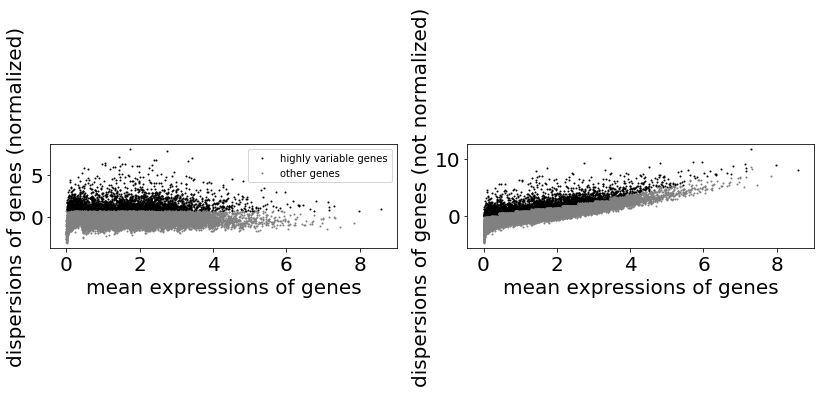

In [58]:
adata = sc.AnnData(X=df.transpose(), obs=df_files)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=3000)
sc.pl.highly_variable_genes(adata)
hvg = adata.var[adata.var["highly_variable"]==True].index

In [32]:
from sbmtm import sbmtm

/home/fvalle/anaconda3/envs/phd/lib/python3.6/site-packages/graph_tool/all.py:40: RuntimeWarning: Error importing draw module, proceeding nevertheless: /home/fvalle/anaconda3/envs/phd/lib/python3.6/site-packages/graph_tool/draw/libgraph_tool_draw.so: undefined symbol: _ZN5Cairo7Context9show_textERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE
  warnings.warn(msg, RuntimeWarning)


In [59]:
hsbm = sbmtm()

In [60]:
hsbm.make_graph_from_BoW_df(df.reindex(index=hvg))

In [61]:
hsbm.save_graph("graph_hv.xml.gz")

In [62]:
del hsbm
gc.collect()

4562

In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15659 entries, ENSG00000000419 to ENSG00000273489
Columns: 1145 entries, 86a373e8-40a9-45b5-a646-6098bc88640e.FPKM.txt.gz to 022cbd07-3e20-4144-b2ab-8c76adffae73.FPKM.txt.gz
dtypes: float64(1145)
memory usage: 137.5+ MB
